<a href="https://colab.research.google.com/github/fuerdagegen/retail-sales-forecasting/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

This notebook starts by installing lightweight dependencies and importing the core libraries needed for data preparation and exploratory analysis.
We keep installations minimal to ensure reproducibility and avoid unnecessary runtime overhead.
Imports are grouped by purpose to make the environment setup clear and easy to maintain.

In [ ]:
# Optional installation for additional tools.
# The line below remains commented to avoid reinstalling on "Run all".
# !pip install -U gdown

In [ ]:
# Install statsmodels if not already available in the Colab environment
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 147.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 24.1 MB/s eta 0:00:00


In [ ]:
# Core numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# Time series and statistical tools
from statsmodels.tsa.seasonal import STL

# Utilities and system tools
import sys
import requests
import io
import gdown

# Google Drive integration for persistent storage
from google.colab import drive

# Loading source data for the Guayas region

In this section we load the raw Favorita data from Google Drive and trim it down to the province of Guayas.

- Small dimensional tables (stores, items, holidays, oil, transactions) are loaded directly from URLs using helper functions.
- The main `train.csv` file is large, so we:
  - download it once to the Colab runtime,
  - read it in chunks,
  - filter to Guayas stores only, and
  - convert the `onpromotion` flag to a nullable boolean.

This gives us a Guayas-focused subset that is small enough for iterative EDA and feature engineering, while still preserving the structure of the original dataset.

In [ ]:
# Helper to build a direct-download Google Drive URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Load a CSV directly from URL (used for relatively small metadata tables)
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()   # stop immediately if the download fails
    return pd.read_csv(io.StringIO(response.text))

# Read all metadata tables except train.csv
def read_metadata_files(file_ids):
    # Load each CSV through the helper functions above
    df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
    df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
    df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
    df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
    df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
    return df_holiday_events, df_items, df_oil, df_stores, df_transactions

# Dictionary with all Google Drive file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load all metadata files
df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)

In [ ]:
# Download the large train.csv using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# Identify all stores belonging to the province of Guayas
store_ids = df_stores[df_stores["state"] == "Guayas"]["store_nbr"].unique()

# Read train.csv in chunks and keep only Guayas stores
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size, dtype={'onpromotion': object}):
    # Convert string values ("True", "False", None) into proper nullable booleans
    chunk['onpromotion'] = chunk['onpromotion'].map({'True': True, 'False': False, None: None})
    chunk['onpromotion'] = chunk['onpromotion'].astype('boolean')

    # Keep only rows belonging to Guayas stores
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)

    # Explicitly drop the original chunk to reduce memory footprint
    del chunk

# Combine the filtered chunks and down-sample for experimentation
df_train = (
    pd.concat(filtered_chunks, ignore_index=True)
      .sample(n=2_000_000, random_state=42)
      .reset_index(drop=True)
)

# Remove intermediate list to free memory
del filtered_chunks

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=726b65e9-e968-467d-b8ce-ed59584e70b4
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:56<00:00, 88.4MB/s]


In [ ]:
df_train.shape

(2000000, 6)

In [ ]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,36402992,2014-12-01,26,1696038,2.234,False
1,40318340,2015-01-31,27,804974,18.000,False
2,2631489,2013-03-06,51,838216,45.000,<NA>
3,24252889,2014-05-23,27,207857,6.000,False
4,46434803,2015-05-10,29,679926,4.000,False


## 🥒 Saving and reloading the prepared dataset

This section saves the filtered Guayas dataset as a pickle file in Drive.  
Pickle preserves column types (including nullable booleans) and avoids rerunning the full chunk-loading loop.  
A short reload snippet is also included for when the notebook is reopened.

In [ ]:
# Save the filtered df_train to Google Drive as a pickle.
# This avoids rerunning the full chunk-processing pipeline after a Colab reset.

from google.colab import drive
drive.mount('/content/drive')

# Path inside Drive where the dataset will be stored
save_path = "/content/drive/MyDrive/retail-sales-forecasting/df_train_original.pkl"

# Persist the DataFrame (keeps dtypes unchanged, including nullable booleans)
df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Mounted at /content/drive
Saved to: /content/drive/MyDrive/retail-sales-forecasting/df_train_original.pkl


In [ ]:
# Reload df_train after a runtime reset.
# Note: this only restores the main training subset.
# Imports and the smaller metadata tables (items, stores, holidays, etc.)
# need to be reloaded separately at the top of the notebook.

drive.mount('/content/drive')

load_path = "/content/drive/MyDrive/retail-sales-forecasting/df_train_original.pkl"
df_train = pd.read_pickle(load_path)

print("DataFrame reloaded.")
df_train.head()

Mounted at /content/drive
DataFrame reloaded, ready to go!


**What needs to be reloaded in a fresh session**

Reloading the pickle restores only `df_train`.  
The following must also be executed again after a reset:

- the import cell (NumPy, pandas, matplotlib, etc.)  
- the helper functions (`make_drive_url`, `load_csv_from_url`, etc.)  
- the metadata tables (`df_items`, `df_stores`, `df_oil`, etc.)

This keeps the notebook reproducible without re-running the expensive chunk loop.

In [ ]:
df_train.shape

(2000000, 6)

# Selecting the top product families

Before moving into feature engineering, the dataset is reduced to the three product families with the highest number of unique items.  
This keeps the number of store–item time series manageable for experimentation while preserving a representative structure of the full dataset.

In [ ]:
# Count how many unique items belong to each family and keep the top three
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)

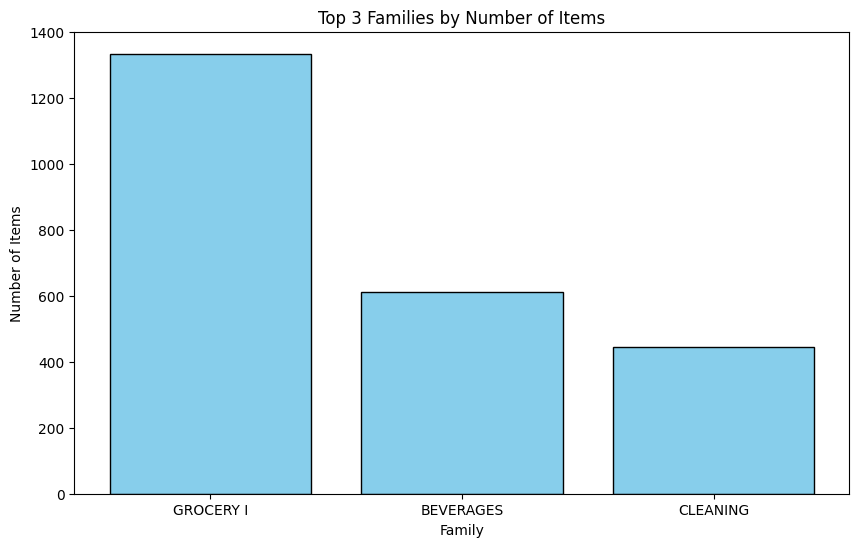

In [ ]:
# Visualize the three families with the largest number of items
plt.figure(figsize=(10, 6))
plt.bar(top_3_families['Family'],
        top_3_families['Item Count'],
        color='skyblue',
        edgecolor='black')

plt.title("Top 3 families by number of items")
plt.xlabel("Family")
plt.ylabel("Number of items")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Filter df_train to include only items that belong to the top three families
item_ids = df_items[df_items['family'].isin(top_3_families['Family'])]['item_nbr'].unique()
df_train_filter = df_train[df_train['item_nbr'].isin(item_ids)]

In [ ]:
# Replace df_train with the filtered version
df_train = df_train_filter.copy()
del df_train_filter

In [ ]:
df_train.shape

(1285637, 6)

# Handling missing values

A quick inspection of nulls helps confirm data quality before feature engineering.  
The main column requiring attention at this stage is `onpromotion`, which contains a mix of boolean values and missing entries.  
Missing promotion flags are treated as `False`, since the dataset does not indicate a third state beyond “on promotion” or “not on promotion”.

In [ ]:
# Check the number of missing values per column
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,240020


In [ ]:
# Convert 'onpromotion' to a nullable boolean and replace missing values with False
df_train['onpromotion'] = (
    df_train['onpromotion']
    .astype('boolean')
    .fillna(False)
)

In [ ]:
# Verify that missing values have been handled
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


## Detecting and handling outliers

Time-series forecasting is sensitive to extreme values, so it is useful to inspect and clean anomalies before feature engineering.  
This section handles two types of irregularities:

1. Negative `unit_sales` values, which represent returns. These are set to zero.  
2. Unusually large spikes within a store–item series, identified via a simple Z-score rule applied per group.

The goal is not aggressive filtering but removing points that would distort rolling statistics and model behaviour.  
A high Z-score threshold (5) is used so that only very extreme spikes are removed and normal demand peaks remain in the data.

In [ ]:
# Inspect negative sales values (these represent returns)
negative_sales = df_train[df_train['unit_sales'] < 0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
34544,5327728,2013-05-08,51,119191,-5.0,False
39436,4362347,2013-04-16,27,469643,-1.0,False
50522,35939934,2014-11-24,51,275823,-17.0,False
52569,61724790,2015-11-10,36,1958186,-6.0,False
72094,112526522,2017-04-15,24,2011910,-8.0,False


In [ ]:
# Replace negative values with zero so returns do not distort demand estimates
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
# Verify that all negative values have been removed
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [ ]:
# Compute Z-scores within each (store, item) group to identify extreme spikes
def calculate_store_item_zscore(group):
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Avoid division by zero if a series is constant
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

In [ ]:
# Apply Z-score calculation to every store–item time series
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(
    calculate_store_item_zscore,
    include_groups=False
)
df_train_grouped.reset_index(drop=True, inplace=True)

# Identify points with unusually high Z-scores (tunable threshold)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3421


,id,date,unit_sales,onpromotion,z_score
158,10200017,2013-08-25,59.0,False,6.235813
388,13913614,2013-11-13,115.0,False,10.142474
794,37946533,2014-12-22,111.0,False,8.103027
937,47159290,2015-05-21,17.0,False,5.871246
1468,13913624,2013-11-13,109.0,False,10.915649


In [ ]:
# Remove extreme outlier rows from the main dataset
df_train = df_train[~df_train['id'].isin(outliers['id'])]

In [ ]:
df_train.shape

(1282216, 6)

# Filling missing calendar days

The Favorita dataset does not include rows for days with zero sales.  
To build consistent time-series features later (rolling windows, lags, seasonality), each store–item pair needs a complete daily calendar.  
This section creates all (store, item, date) combinations within the dataset’s date range and fills missing `unit_sales` values with zero.

In [ ]:
# Convert 'date' to datetime to ensure proper merging and calendar handling
df_train.loc[:, 'date'] = pd.to_datetime(df_train['date'])

# Determine the date range present in the dataset
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Build a complete daily calendar
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


In [ ]:
# Build all (store, item) pairs observed in the dataset
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()

# Cross join to produce all (store, item, date) combinations
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,27,804974,2013-01-02
1,27,804974,2013-01-03
2,27,804974,2013-01-04
3,27,804974,2013-01-05
4,27,804974,2013-01-06
...,...,...,...
34554816,30,2048242,2017-08-11
34554817,30,2048242,2017-08-12
34554818,30,2048242,2017-08-13
34554819,30,2048242,2017-08-14


In [ ]:
# Ensure 'date' remains in datetime format after earlier operations
df_train['date'] = pd.to_datetime(df_train['date'])

# Merge with the original data so missing dates appear as NaN
df_filled = all_combinations.merge(
    df_train,
    on=['store_nbr', 'item_nbr', 'date'],
    how='left'
)

# Replace missing sales with zero for days without transactions
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,27,804974,2013-01-02,NaN,0.0,<NA>
1,27,804974,2013-01-03,NaN,0.0,<NA>
2,27,804974,2013-01-04,NaN,0.0,<NA>
3,27,804974,2013-01-05,NaN,0.0,<NA>
4,27,804974,2013-01-06,NaN,0.0,<NA>


In [ ]:
# Replace df_train with the fully filled calendar
df_train = df_filled.copy()
del df_filled

In [ ]:
# Restore nullable boolean dtype for 'onpromotion' after the merge
df_train['onpromotion'] = df_train['onpromotion'].astype('boolean').fillna(False)

In [ ]:
df_train.shape

(34554821, 6)

# Feature engineering

To prepare the dataset for modelling, this section adds basic time-based features and a simple rolling statistic.  
These features help capture seasonality, weekly patterns, and short-term trends in each store–item series.

In [ ]:
# Extract calendar components used by many forecasting models
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek   # Monday=0 ... Sunday=6

In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week
0,27,804974,2013-01-02,NaN,0.0,False,2013,1,2,2
1,27,804974,2013-01-03,NaN,0.0,False,2013,1,3,3
2,27,804974,2013-01-04,NaN,0.0,False,2013,1,4,4
3,27,804974,2013-01-05,NaN,0.0,False,2013,1,5,5
4,27,804974,2013-01-06,NaN,0.0,False,2013,1,6,6


In [ ]:
# Compute a 7-day rolling mean per (item, store)
# Sorting ensures that each group is in chronological order
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True)

df_train["unit_sales_7d_avg"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)

In [ ]:
# Quick look at the rolling-average feature for a single series
store_id = df_train.iloc[0]['store_nbr']
item_id = df_train.iloc[0]['item_nbr']

sample = (
    df_train[(df_train['store_nbr'] == store_id) &
             (df_train['item_nbr'] == item_id)]
    .sort_values("date")
)

sample.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,NaN,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,NaN,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,NaN,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,NaN,0.0,False,2013,1,6,6,0.0


In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,NaN,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,NaN,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,NaN,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,NaN,0.0,False,2013,1,6,6,0.0


## 🥒 Saving and reloading the cleaned dataset

After feature engineering, the dataset is saved again so the notebook can be resumed without recomputing the preparation steps.  
Pickle preserves column types and makes it easy to continue work in a fresh Colab session.

In [ ]:
# Save the cleaned df_train to Drive as a pickle to avoid recomputing preparation steps
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/retail-sales-forecasting/df_train_clean.pkl"

df_train.to_pickle(save_path)
print(f"Saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/retail-sales-forecasting/df_train_clean.pkl


In [ ]:
# Reload the cleaned dataset after a runtime reset.
# Note: only df_train is restored here. Imports and metadata tables
# (items, stores, holidays, oil, transactions) must be loaded again at the top.

drive.mount('/content/drive')

load_path = "/content/drive/MyDrive/retail-sales-forecasting/df_train_clean.pkl"
df_train = pd.read_pickle(load_path)

print("DataFrame reloaded.")

Mounted at /content/drive
DataFrame reloaded, ready to go!


**What needs to be reloaded in a fresh session**

Reloading this pickle restores only the cleaned `df_train`.  
The following must also be executed again after a runtime reset:

- the import cell (NumPy, pandas, matplotlib, etc.)  
- the helper functions (`make_drive_url`, `load_csv_from_url`, etc.)  
- the metadata tables (`df_items`, `df_stores`, `df_oil`, `df_transactions`, etc.)

This keeps the notebook reproducible without re-running the full preparation pipeline.

In [ ]:
df_train.shape

# Visualizations

These plots provide a quick overview of demand patterns in the Guayas subset.  
The goal is to highlight long-term trends and recurring seasonal structure before moving into modeling.

## Sales over time (aggregated)

This aggregated daily time-series helps reveal long-term trends, seasonal peaks, and irregular drops across the entire region.

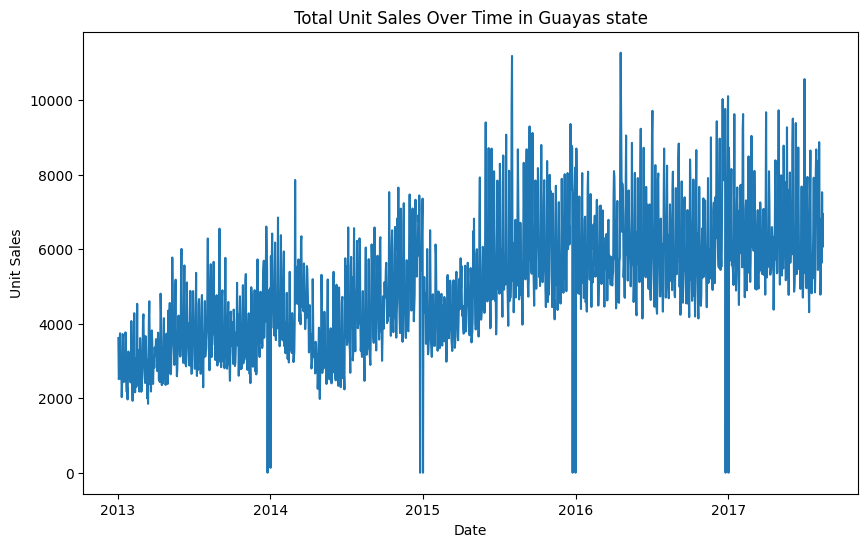

In [ ]:
# Total daily unit sales across all stores and items
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total unit sales over time in Guayas state')
plt.xlabel('Date')
plt.ylabel('Unit sales')
plt.show()

## Sales trend by year and month

A year–month pivot highlights broader seasonal structure and helps identify annual growth patterns and unusual months.

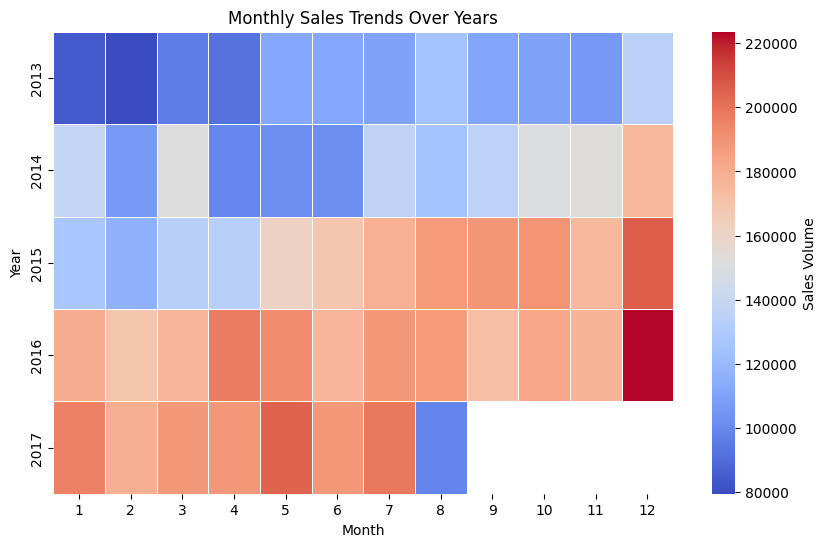

In [ ]:
# Aggregate unit sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

plt.figure(figsize=(10, 6))

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales volume'}
)

plt.title('Monthly sales trends over years')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

## Examining the impact of holidays

To understand whether special days boost or reduce demand, holiday information is joined onto the daily sales data.  
The focus is on national holidays and those specific to Guayaquil.  
Average unit sales are then compared across different holiday types and regular work days.

In [ ]:
# Quick look at the holiday events table
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Keep only holidays that apply nationally or to Guayaquil
df_holiday_events = df_holiday_events[
    (df_holiday_events['locale_name'] == 'Guayaquil') |
    (df_holiday_events['locale_name'] == 'Ecuador')
]

In [ ]:
# Ensure the holiday date column is in datetime format
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-08-10 → 2017-12-26


In [ ]:
# Join holiday information onto the daily sales table
# Keep only the holiday type and rename it to 'day type'
df_train_holiday = pd.merge(
    df_train,
    df_holiday_events[['date', 'type']].rename(columns={'type': 'day type'}),
    on='date',
    how='left'   # non-holiday days will have NaN in 'day type'
)

# Treat days without a holiday entry as regular work days
df_train_holiday['day type'] = df_train_holiday['day type'].fillna('Work Day')

In [ ]:
df_train_holiday.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,day type
0,24,96995,2013-01-02,NaN,0.0,False,2013,1,2,2,0.0,Work Day
1,24,96995,2013-01-03,NaN,0.0,False,2013,1,3,3,0.0,Work Day
2,24,96995,2013-01-04,NaN,0.0,False,2013,1,4,4,0.0,Work Day
3,24,96995,2013-01-05,NaN,0.0,False,2013,1,5,5,0.0,Work Day
4,24,96995,2013-01-06,NaN,0.0,False,2013,1,6,6,0.0,Work Day


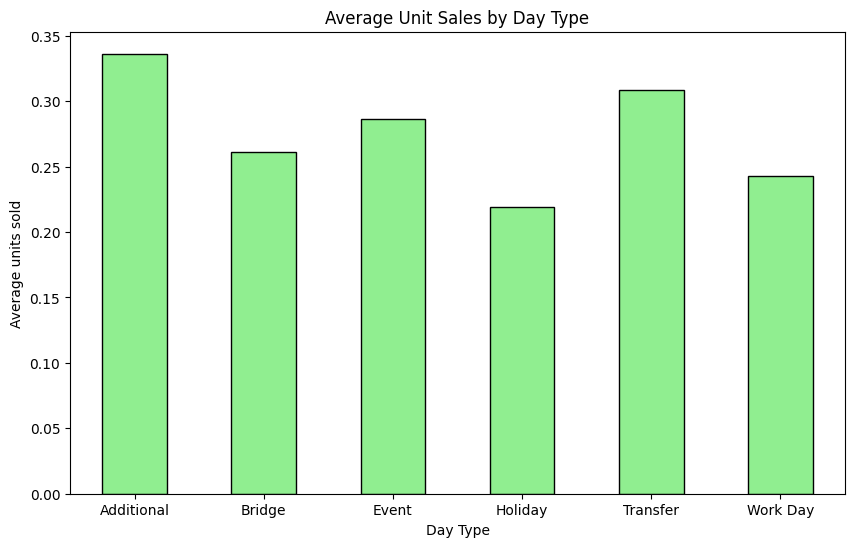

In [ ]:
# Average units sold by day type (holiday categories vs regular work days)
holiday_sales = df_train_holiday.groupby('day type')['unit_sales'].mean()

plt.figure(figsize=(10, 6))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average unit sales by day type')
plt.ylabel('Average units sold')
plt.xlabel('Day type')
plt.xticks(rotation=0)
plt.show()

## Investigating the relationship with oil prices

Since Ecuador’s economy is closely linked to oil production, it can be useful to compare daily sales trends with global oil price movements.  
This section merges the WTI oil price series with aggregated daily sales to explore whether broad macro patterns move together with retail demand.

In [ ]:
# Ensure the oil data has a proper datetime column
df_oil['date'] = pd.to_datetime(df_oil['date'])

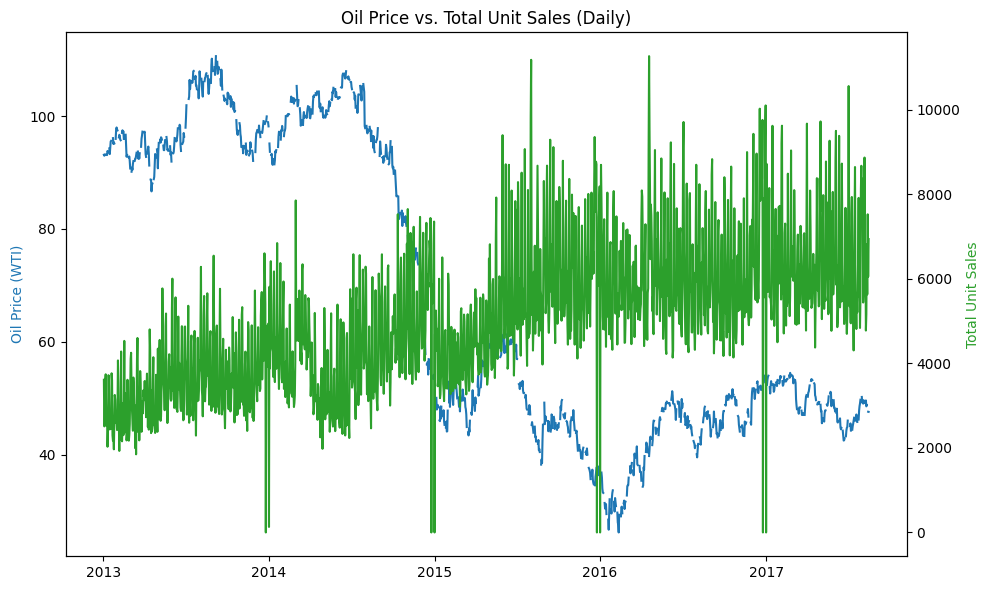

In [ ]:
# Aggregate daily unit sales across all stores and items
daily_sales = (
    df_train
      .groupby('date', as_index=False)['unit_sales']
      .sum()
)

# Merge daily sales with oil prices by date
daily_sales_oil = daily_sales.merge(df_oil, on='date', how='left')

# Plot oil price (WTI) and total unit sales on aligned axes
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(daily_sales_oil['date'], daily_sales_oil['dcoilwtico'],
         color='tab:blue', label='Oil price')
ax1.set_ylabel('Oil price (WTI)', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(daily_sales_oil['date'], daily_sales_oil['unit_sales'],
         color='tab:green', label='Unit sales')
ax2.set_ylabel('Total unit sales', color='tab:green')

plt.title('Oil price vs. total unit sales (daily)')
plt.tight_layout()
plt.show()

# Autocorrelation and stationarity checks

Understanding how daily sales relate to their own past values helps decide which forecasting approaches are suitable.  
This section looks at autocorrelation patterns, rolling statistics, the ADF test, and an STL decomposition to assess trend and seasonality strength.

## Autocorrelation

Daily sales are aggregated and used to inspect how strongly the series depends on previous values across different lags.

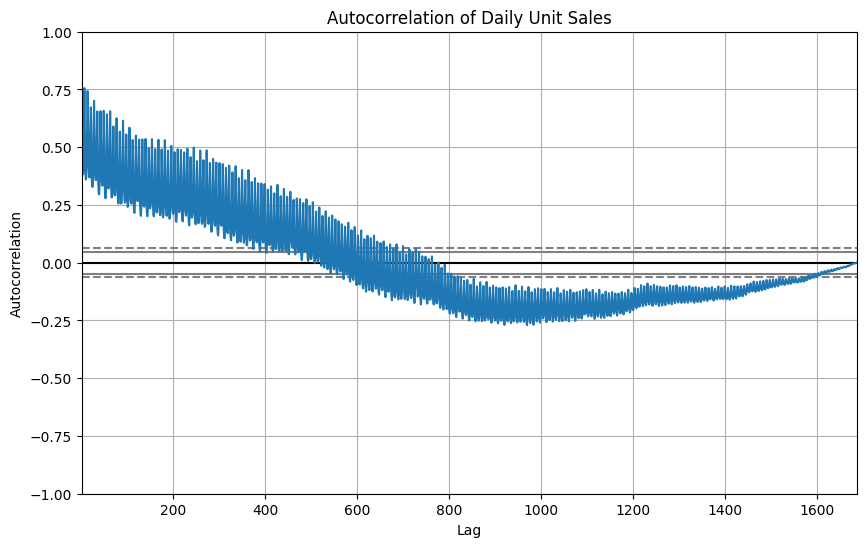

In [ ]:
# Aggregate daily unit sales across all stores and items
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot the autocorrelation structure
plt.figure(figsize=(10, 6))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of daily unit sales')
plt.show()

## Stationarity checks

Stationarity is important for many classical time-series models.  
Visual checks, rolling mean/variance, and the ADF test give an indication of whether strong trend or seasonality is present.

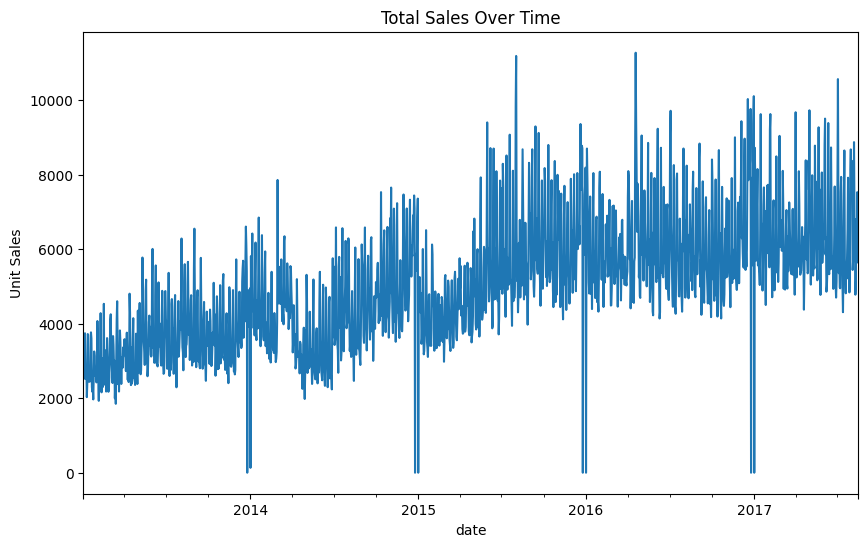

In [ ]:
# Plot the raw series for a visual assessment of trend/non-stationarity
sales_by_date.plot(figsize=(10, 6), title='Total sales over time')
plt.ylabel('Unit sales')
plt.show()

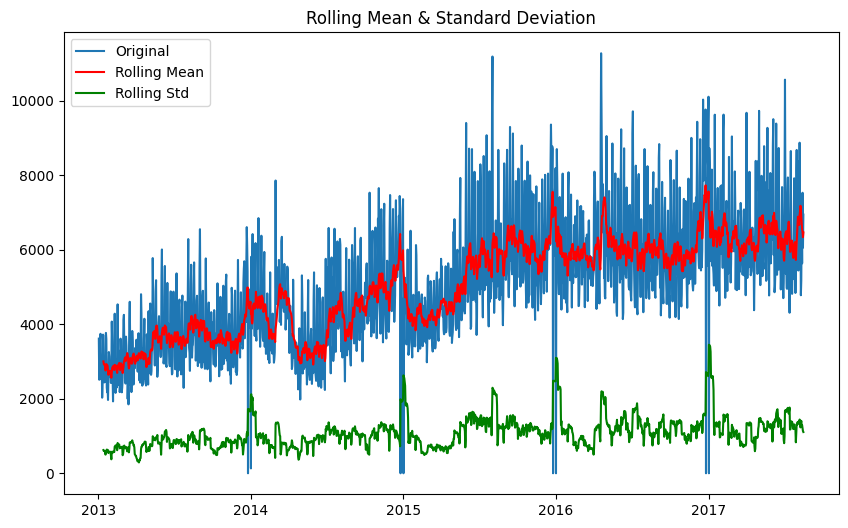

In [ ]:
# Rolling statistics to observe how mean and variance evolve over time
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling mean', color='red')
plt.plot(rolling_std, label='Rolling std', color='green')
plt.title('Rolling mean & standard deviation')
plt.legend()
plt.show()

In [ ]:
# Augmented Dickey–Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)

print("ADF statistic:", result[0])  # More negative = more evidence against unit root
print("p-value:", result[1])       # p < 0.05 → reject non-stationarity

ADF Statistic: -2.334503175834797
p-value: 0.1610813018430285


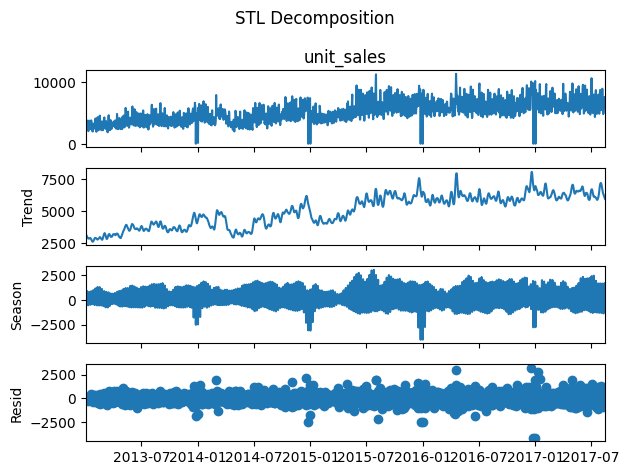

In [ ]:
# STL decomposition to separate trend, seasonality, and residuals
# period=7 reflects weekly seasonality in retail
stl = STL(sales_by_date, period=7)
res = stl.fit()

# Plot the decomposition components
res.plot()
plt.suptitle("STL decomposition")
plt.tight_layout()
plt.show()

In [ ]:
# Compute strength metrics following Hyndman's definition
# Strength = 1 - Var(residuals) / Var(component + residuals)

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of trend: {trend_strength:.2f}")         # closer to 1 → trend explains more of the variation
print(f"Strength of seasonality: {seasonal_strength:.2f}") # closer to 1 → seasonality explains more of the variation

Strength of Trend: 0.85
Strength of Seasonality: 0.76


# Summary

This notebook prepares the Favorita dataset for forecasting work focused on the province of Guayas.  
The workflow covered the full data-prep pipeline:

- loading and filtering the raw tables,  
- selecting the top product families,  
- handling missing values and outliers,  
- creating a complete daily calendar for every store–item pair,  
- adding basic time-based features,  
- running exploratory visualizations,  
- and exporting a cleaned dataset for modelling.

A few early insights stood out during EDA:

- Daily sales show clear long-term growth and recurring seasonal patterns.  
- Monthly heatmaps highlight consistent peaks around year-end and local fluctuations across months.  
- Holidays have mixed effects: some categories of holidays lift demand, while others lower it.  
- Oil prices and sales do not move together in any obvious way at a daily level.  
- Autocorrelation indicates strong short-lag dependence, confirming meaningful temporal structure.  
- The ADF test suggests the aggregated series is not stationary.  
- STL decomposition shows strong trend (≈0.85) and strong weekly seasonality (≈0.76).

The resulting `df_train` is now cleaned, structured, and ready for feature expansion and model development.

# Export

The cleaned and filtered dataset is exported for use in later notebooks.  
This step drops unused columns and applies a date filter before saving the final CSV to Drive.

In [ ]:
# Quick preview before export
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,NaN,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,NaN,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,NaN,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,NaN,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,NaN,0.0,False,2013,1,6,6,0.0


In [ ]:
# Remove 'id' since it is no longer needed
df_train = df_train.drop('id', axis=1)

In [ ]:
# Apply date cutoff for the forecasting horizon
max_date = '2014-04-01'
df_train = df_train[df_train['date'] <= max_date]
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,0.0,False,2013,1,6,6,0.0


In [ ]:
# Optional sampling step to reduce the dataset size for lighter experiments
# df_train = df_train.sample(n=300_000).reset_index(drop=True)

In [ ]:
# Check final shape before saving
df_train.shape

(9319765, 10)

In [ ]:
# Save the exported dataset to Drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/retail-sales-forecasting/df_train_sample.csv"
df_train.to_csv(save_path, index=False)

print(f"DataFrame saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame saved to: /content/drive/MyDrive/retail-sales-forecasting/df_train_sample_large.csv
